# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

In [7]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, random_seed):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, random_seed):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128 + action_size, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, state, action):
        x = F.relu(self.fc1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.ouprocess = OUProcess(action_size)

        # Networks for actor
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optim = optim.Adam(self.actor_local.parameters(), lr=LR)
        
        # Networks for critic
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
        self.critic_optim = optim.Adam(self.critic_local.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action_values = self.actor_local(state)
        self.actor_local.train()
        return np.clip(action_values.cpu().data.numpy() + self.ouprocess.sample(), -1, 1)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        ### step 1: train critic
        next_actions = self.actor_target(next_states).detach()
        Q_expected_next = self.critic_target(next_states, next_actions).detach()
        Q_actual = rewards + Q_expected_next * GAMMA
        
        Q_expected = self.critic_local(states, actions)
        
        loss_critic = F.mse_loss(Q_expected, Q_actual)
        
        self.critic_optim.zero_grad()
        loss_critic.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optim.step()
        
        ### step 2: train actor
        next_actions = self.actor_local(next_states)
        loss_actor = -self.critic_local(next_states, next_actions).mean()
        
        self.actor_optim.zero_grad()
        loss_actor.backward()
        self.actor_optim.step()
        
        ### step 3: soft update networks
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class OUProcess:
    def __init__(self, size, mu=0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [9]:
agent = Agent(state_size, action_size)

In [10]:
PRINT_EVERY = 10

def ddpg(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations   
        rewards = []
        for t in range(max_t):
            action = agent.act(state)
            brain_info = env.step(action)[brain_name]
            next_state = brain_info.vector_observations
            reward = brain_info.rewards
            done = brain_info.local_done
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            
            rewards.append(reward[0])
            if np.any(done):
                break
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        if (i_episode % PRINT_EVERY == 0):
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores
    
scores = ddpg()

Episode 10	Average Score: 0.55
Episode 20	Average Score: 0.66
Episode 30	Average Score: 0.72
Episode 40	Average Score: 0.70
Episode 50	Average Score: 0.83
Episode 60	Average Score: 0.89
Episode 70	Average Score: 1.00
Episode 80	Average Score: 1.11
Episode 90	Average Score: 1.20
Episode 100	Average Score: 1.29
Episode 110	Average Score: 1.50
Episode 120	Average Score: 1.89
Episode 130	Average Score: 2.32
Episode 140	Average Score: 2.85
Episode 150	Average Score: 3.44
Episode 160	Average Score: 3.99
Episode 170	Average Score: 4.60
Episode 180	Average Score: 5.38
Episode 190	Average Score: 6.50
Episode 200	Average Score: 7.83
Episode 210	Average Score: 9.16
Episode 220	Average Score: 10.27
Episode 230	Average Score: 11.57
Episode 240	Average Score: 13.11
Episode 250	Average Score: 14.58
Episode 260	Average Score: 16.49
Episode 270	Average Score: 18.53
Episode 280	Average Score: 20.04
Episode 290	Average Score: 21.36
Episode 300	Average Score: 22.42
Episode 310	Average Score: 23.56
Episode

In [11]:
env.close()

Text(0.5,0,'Episode')

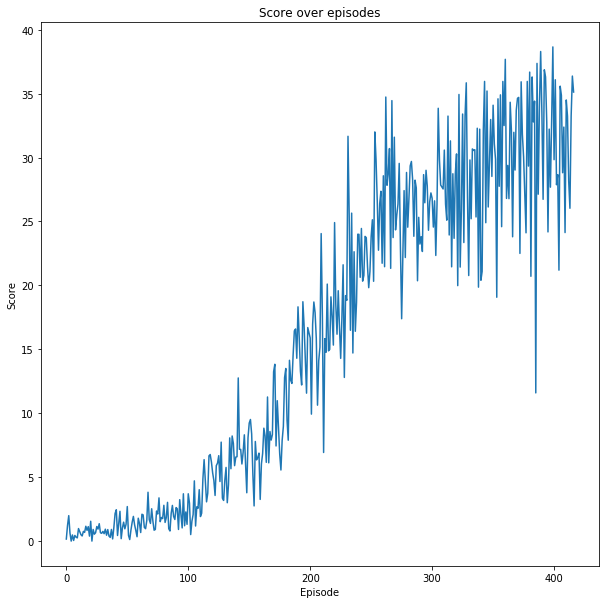

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(len(scores)), scores)
ax.set_title("Score over episodes")
ax.set_ylabel("Score")
ax.set_xlabel("Episode")

In [13]:
torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')